In [10]:
import numpy as np
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.parmest import parmest

## Model
ln(PCB) = m $\times$ age + b <br>

Where, <br>
PCB = Concentration of polychlirinated biphenyls (PCBs)<br>
m, b = Parameters to estimate

## Data

In [11]:
"""
This data and the equation (``Expression``) in pyomo_model is from "Nonlinear Regression Analysis
and Its Applications - 1988 - Bates" p.3 Example
"""
data = {
    'Age (years)': [1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 11, 12, 12, 12],
    'PCB Concentration (ppm)': [0.6, 1.6, 0.5, 1.2, 2.0, 1.3, 2.5, 2.2, 2.4, 1.2, 3.5, 4.1, 5.1, 5.7, 3.4,
                                9.7, 8.6, 4.0, 5.5, 10.5, 17.5, 13.4, 4.5, 30.4, 12.4, 13.4, 26.2, 7.4]
}

## Creating a pyomo model

In [ ]:
def pyomo_model(data):
    # Create the concrete model
    model = pyo.ConcreteModel()

    # Add variables in the concrete model
    # Vars
    model.m = pyo.Var(initialize = 0.2)  # Slope
    model.b = pyo.Var(initialize = 0.03)  # intercept
    model.age = pyo.Var(initialize = float(data["Age (years)"]))  # Inputs
    model.ln_pcb = pyo.Var(initialize=float(np.log(data["PCB Concentration"])))  # Outputs

    """
    We will express the equation relating the paramaters and vars as an `Constraint`.
    equation: ln(PCB) = m + b * age

    """

    model.eq1 = pyo.Constraint(expr = model.ln_pcb == model.m * model.age + model.b)

    return model

## Creating AgeFind class

In [ ]:
class PCB_Conc(Experiment):
    
    # Defining the constructor
    def __init__(self, data):
        self.data = data
        self.model = None

    
    def get_labeled_model(self):
        """
        get_labeled_model is a mandatory method in both parmest and DOE. In this method, we 
        build the model, and then finalize it.
        """
        if self.model is None:
            self.create_model()
            self.label_model()
            
        return self.model


    # Create flixible model without data
    def create_model(self):    
        """
        Here, we will create different variables, parameters, and equations
        """  
        self.model = pyomo_model(self.data)  
        # we don't need to create new model, since we have already created a model in pyomo_model.
        # so we are just calling that function here.
        
        return self.model

    
    def label_model(self):
        """
        The model is updated with outputs, inputs, errors and unknown parameters
        This makes the model labeled with full experiment
        """
        model = self.model

        # Experiment outputs
        model.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        # passing the experiment data as a `list` of `tuple` in the experiment_outputs
        model.experiment_outputs.update([
            (model.ln_pcb, pyo.log(self.data['PCB Concentration']))
            ])
            

        # Experiment inputs
        model.experiment_inputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        model.experiment_inputs[model.age] = pyo.value(model.age)

        # Unknown parameters to be estimated
        model.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        model.unknown_parameters.update((k, pyo.value(k)) for k in [model.m, model.b])

        # Measurement error
        model.measurement_error = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        model.measurement_error[model.ln_pcb] = 0.1  # assuming a constant measurement error

        
        return model          

## Estimate the parameters and covariance using `Parmest`

In [14]:
data_lc = [
    {"Age (years)": age, "PCB Concentration": PCB_Concentration} for age, PCB_Concentration in zip(data['Age (years)'], data['PCB Concentration (ppm)'])
]

exp_list = []
n_data = len(data_lc)
for i in range(n_data):
    exp_list.append(PCB_Conc(data_lc[i]))
    
# Creating the object for Estimator
pest = parmest.Estimator( exp_list, obj_function = "SSE", tee = True)

# Calculating the objective function value and parameter values, `theta`
obj, theta = pest.theta_est()
cov = pest.cov_est()


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [15]:
print("theta values:")
print(theta)

print("\nSSE value: ", obj)

print("\nCovariance matrix:")
print(cov)

theta values:
m    0.235628
b    0.154022
dtype: float64

SSE value:  1.4778570774267266e-16

Covariance matrix:
          m         b
m  0.000032 -0.000180
b -0.000180  0.001394


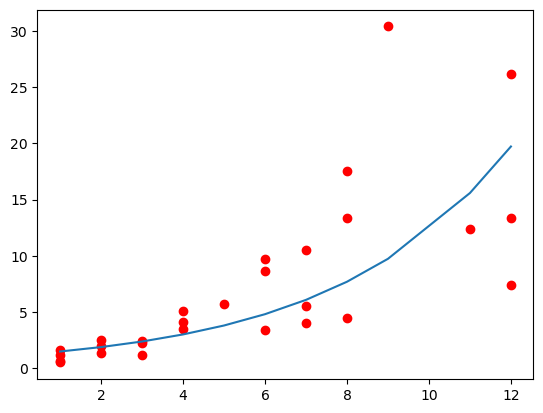

In [16]:
# assigning the calculated parameter values. the output `theta` is a pandas data series.
m = theta.loc["m"]
b = theta.loc["b"]

plt.scatter(data['Age (years)'], data['PCB Concentration (ppm)'], color = 'red')

pcb_calc = lambda age : np.exp(b + m * age)
plt.plot(data['Age (years)'], pcb_calc(np.array(data['Age (years)'])))

## Design of Experiments

In [17]:
from pyomo.contrib.doe import DesignOfExperiments

In [19]:
FIM = np.zeros((2,2))
for i in range(len(data_lc)):
    experiment_doe = PCB_Conc(data_lc[i])
    obj_doe = DesignOfExperiments(experiment_doe,step= 0.01)
    FIM += obj_doe.compute_FIM()

FIM

array([[ 184638.16289942,  460240.24010948],
       [ 460240.24010948, 1585137.5880486 ]])

### Optimize the experiments

In [21]:
# The FIM we got from our data is the prior FIM for DOE
experiment_doe = PCB_Conc(data_lc[0])  # We can use any experimental data we want,
# does nt matter which one we use here.
obj_doe = DesignOfExperiments(experiment_doe,step= 0.01, prior_FIM=FIM)

# Optimize the experiment
obj_doe.run_doe()

In [22]:
# Show the results from DOE
obj_doe.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'FIM': [[np.float64(70367628.98399293), np.float64(-31350232.49662795)],
  [np.float64(-31350232.49662795), np.float64(16003248.926652128)]],
 'Sensitivity Matrix': [[np.float64(837.7528920934474),
   np.float64(-379.7118820711768)]],
 'Experiment Design': [246.67834293725224],
 'Experiment Design Names': ['age'],
 'Experiment Outputs': [-4.49740251500234],
 'Experiment Output Names': ['ln_pcb'],
 'Unknown Parameters': [2.7141439363841786, -674.0179312354423],
 'Unknown Parameter Names': ['m', 'b'],
 'Measurement Error': [-4.49740251500234],
 'Measurement Error Names': ['ln_pcb'],
 'Prior FIM': [[np.float64(184638.1628994233), np.float64(460240.24010948424)],
  [np.float64(460240.24010948424), np.float64(1585137.5880486022)]],
 'Objective expression': 'determinant',
 'log10 A-opt': np.float64(-6.219798855878